# Model 1: Predictive Power of Congressional Trading

This notebook tests whether congressional trading activity improves out-of-sample prediction of S&P 500 returns beyond publicly available information.

**Framework:**
- Grossman-Stiglitz (1980): Theoretical motivation (informed traders)
- Mullainathan-Spiess (2017): ML as tool for prediction, not causal inference
- Campbell-Thompson (2008): Out-of-sample R² methodology
- Gu-Kelly-Xiu (2020): ML model comparison in asset pricing

**Key Principle:** We test whether congressional trades contain *predictive* information, not whether they *cause* returns. The distinction matters for interpretation.

---

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Setup complete')

Setup complete


In [2]:
# Paper-quality plot settings
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 0.8,
    'axes.grid': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'grid.alpha': 0.3,
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette (colorblind-friendly)
COLORS = {
    'primary': '#2E4057',      # Dark blue-gray
    'secondary': '#698F3F',    # Olive green
    'accent': '#C44536',       # Muted red
    'neutral': '#8B8B8B',      # Gray
    'light': '#D4D4D4',        # Light gray
    'public': '#4A7C59',       # Green (public model)
    'congress': '#C44536',     # Red (congressional model)
    'benchmark': '#8B8B8B',    # Gray (benchmark)
}

# Output directory
OUTPUT_DIR = 'outputs/Model_1'
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 1. Load Data

In [3]:
# Load prediction base
base = pd.read_csv('data/prediction_bases/base_sp500_monthly.csv', index_col=0)
base.index = pd.PeriodIndex(base.index, freq='M')

print(f'Observations: {len(base)}')
print(f'Features: {len(base.columns)}')
print(f'Period: {base.index.min()} to {base.index.max()}')

Observations: 143
Features: 92
Period: 2013-01 to 2024-11


In [4]:
# Drop any remaining NaN
base = base.dropna()
print(f'After dropna: {len(base)} observations')

After dropna: 143 observations


## 2. Define Feature Sets

Following Mullainathan-Spiess (2017): the comparison between models with different feature sets tells us about the *predictive* content of the additional variables.

In [5]:
# Target
TARGET = 'ret_sp500_1m'

# Public information only (what any investor can observe)
FEATURES_PUBLIC = [
    'sp500_ret_lag',
    'sp500_ret_lag2', 
    'sp500_vol',
    'vix',
    'sp500_mom_3m',
    'sp500_mom_6m',
]

# Congressional features (our contribution)
FEATURES_CONGRESS = [col for col in base.columns if col.startswith('cong_')]

# Combined
FEATURES_FULL = FEATURES_PUBLIC + FEATURES_CONGRESS

# Verify all features exist
FEATURES_PUBLIC = [f for f in FEATURES_PUBLIC if f in base.columns]
FEATURES_CONGRESS = [f for f in FEATURES_CONGRESS if f in base.columns]
FEATURES_FULL = FEATURES_PUBLIC + FEATURES_CONGRESS

print(f'Public features: {len(FEATURES_PUBLIC)}')
print(f'Congressional features: {len(FEATURES_CONGRESS)}')
print(f'Total features: {len(FEATURES_FULL)}')

Public features: 6
Congressional features: 83
Total features: 89


In [6]:
# Feature sets for comparison
FEATURE_SETS = {
    'Public Only': FEATURES_PUBLIC,
    'Public + Congressional': FEATURES_FULL,
}

print('Feature sets defined:')
for name, features in FEATURE_SETS.items():
    print(f'  {name}: {len(features)} features')

Feature sets defined:
  Public Only: 6 features
  Public + Congressional: 89 features


## 3. Evaluation Framework

Following Campbell-Thompson (2008) and Gu-Kelly-Xiu (2020):
- Out-of-sample R² relative to historical average benchmark
- Expanding window estimation (no look-ahead bias)
- Diebold-Mariano test for forecast comparison

In [7]:
def oos_r2(y_true, y_pred, y_benchmark):
    """
    Out-of-sample R² (Campbell-Thompson 2008).
    
    R²_OOS = 1 - (SSE_model / SSE_benchmark)
    
    Positive value: model beats benchmark
    Zero: model equals benchmark  
    Negative: model worse than benchmark
    """
    sse_model = np.sum((y_true - y_pred) ** 2)
    sse_bench = np.sum((y_true - y_benchmark) ** 2)
    
    if sse_bench == 0:
        return np.nan
    
    return 1 - (sse_model / sse_bench)


def diebold_mariano(e1, e2, h=1):
    """
    Diebold-Mariano test for equal predictive accuracy.
    
    H0: E[L(e1)] = E[L(e2)] (equal forecast accuracy)
    H1: E[L(e1)] ≠ E[L(e2)]
    
    Returns (statistic, p-value, preferred model)
    Positive statistic: model 2 is better
    """
    d = e1**2 - e2**2  # Loss differential (squared error)
    
    n = len(d)
    d_mean = np.mean(d)
    d_var = np.var(d, ddof=1)
    
    if d_var == 0:
        return 0, 1, 'Equal'
    
    # Harvey-Leybourne-Newbold correction for small samples
    dm_stat = d_mean / np.sqrt(d_var / n)
    
    # Two-sided p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    
    preferred = 'Model 2' if dm_stat > 0 else 'Model 1' if dm_stat < 0 else 'Equal'
    
    return dm_stat, p_value, preferred


def clark_west(y_true, y_pred_restricted, y_pred_unrestricted):
    """
    Clark-West (2007) test for nested models.
    
    Tests if the unrestricted model (with more variables) predicts
    better than the restricted model, adjusting for parameter estimation.
    
    H0: Restricted model is better or equal
    H1: Unrestricted model is better
    """
    e1 = y_true - y_pred_restricted
    e2 = y_true - y_pred_unrestricted
    
    # MSPE adjustment
    adj = (y_pred_restricted - y_pred_unrestricted) ** 2
    f = e1**2 - (e2**2 - adj)
    
    n = len(f)
    t_stat = np.mean(f) / (np.std(f, ddof=1) / np.sqrt(n))
    p_value = 1 - stats.norm.cdf(t_stat)  # One-sided
    
    return t_stat, p_value

In [8]:
class ExpandingWindowForecaster:
    """
    Expanding window forecaster with proper out-of-sample evaluation.
    
    At each time t:
    1. Train on [0, t-1]
    2. Predict t
    3. Store prediction and actual
    4. Advance to t+1
    
    This ensures no look-ahead bias.
    """
    
    def __init__(self, min_train_periods=36):
        self.min_train = min_train_periods
        
    def forecast(self, data, target, features, model, scale=True):
        """
        Generate out-of-sample forecasts.
        
        Returns: predictions, actuals, dates
        """
        df = data[[target] + features].dropna().copy()
        
        if len(df) <= self.min_train:
            return np.array([]), np.array([]), []
        
        predictions = []
        actuals = []
        dates = []
        
        for t in range(self.min_train, len(df)):
            # Training data: [0, t-1]
            train = df.iloc[:t]
            test = df.iloc[[t]]
            
            X_train = train[features].values
            y_train = train[target].values
            X_test = test[features].values
            y_test = test[target].values[0]
            
            # Scale (fit only on training)
            if scale:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            
            # Fit and predict
            try:
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
            except Exception as e:
                pred = np.nan
            
            predictions.append(pred)
            actuals.append(y_test)
            dates.append(df.index[t])
        
        return np.array(predictions), np.array(actuals), dates
    
    def historical_average(self, data, target):
        """
        Benchmark: expanding window historical average.
        """
        df = data[[target]].dropna().copy()
        
        predictions = []
        actuals = []
        
        for t in range(self.min_train, len(df)):
            hist_mean = df[target].iloc[:t].mean()
            predictions.append(hist_mean)
            actuals.append(df[target].iloc[t])
        
        return np.array(predictions), np.array(actuals)

## 4. Models

We compare multiple algorithms to ensure results are not driven by model choice.

In [9]:
# Model specifications
MODELS = {
    'OLS': LinearRegression(),
    'Ridge': RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100]),
    'LASSO': LassoCV(cv=5, max_iter=10000, random_state=RANDOM_STATE),
    'ElasticNet': ElasticNetCV(cv=5, max_iter=10000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=3,
        min_samples_leaf=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=2,
        learning_rate=0.05,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    ),
}

## 5. Run Model Comparison

In [10]:
# Initialize forecaster
forecaster = ExpandingWindowForecaster(min_train_periods=36)

# Benchmark: Historical Average
ha_pred, ha_actual = forecaster.historical_average(base, TARGET)
print(f'Benchmark (Historical Average): {len(ha_pred)} forecasts')

Benchmark (Historical Average): 107 forecasts


In [11]:
# Store all results
results = []
all_forecasts = {'Historical Average': {'pred': ha_pred, 'actual': ha_actual}}

# Run all combinations
for feat_name, features in FEATURE_SETS.items():
    for model_name, model in MODELS.items():
        
        print(f'Running: {model_name} with {feat_name}...')
        
        # Get forecasts
        pred, actual, dates = forecaster.forecast(base, TARGET, features, model)
        
        if len(pred) == 0:
            continue
        
        # Align with benchmark
        min_len = min(len(pred), len(ha_pred))
        pred = pred[:min_len]
        actual = actual[:min_len]
        ha = ha_pred[:min_len]
        
        # Store forecasts
        key = f'{model_name}_{feat_name}'
        all_forecasts[key] = {'pred': pred, 'actual': actual, 'dates': dates[:min_len]}
        
        # Metrics
        r2 = oos_r2(actual, pred, ha)
        mse = np.mean((actual - pred) ** 2)
        mse_ha = np.mean((actual - ha) ** 2)
        
        # DM test vs benchmark
        e_model = actual - pred
        e_ha = actual - ha
        dm_stat, dm_pval, _ = diebold_mariano(e_ha, e_model)
        
        results.append({
            'Model': model_name,
            'Features': feat_name,
            'N_features': len(features),
            'N_forecasts': len(pred),
            'OOS_R2': r2,
            'OOS_R2_pct': r2 * 100,
            'MSE': mse,
            'RMSE': np.sqrt(mse),
            'MSE_HA': mse_ha,
            'DM_stat': dm_stat,
            'DM_pval': dm_pval,
        })

results_df = pd.DataFrame(results)
print(f'\nCompleted: {len(results_df)} model-feature combinations')

Running: OLS with Public Only...
Running: Ridge with Public Only...
Running: LASSO with Public Only...
Running: ElasticNet with Public Only...
Running: RandomForest with Public Only...
Running: GradientBoosting with Public Only...
Running: OLS with Public + Congressional...
Running: Ridge with Public + Congressional...
Running: LASSO with Public + Congressional...
Running: ElasticNet with Public + Congressional...
Running: RandomForest with Public + Congressional...
Running: GradientBoosting with Public + Congressional...

Completed: 12 model-feature combinations


## 6. Results

In [12]:
# Main results table
print('OUT-OF-SAMPLE PREDICTION RESULTS')
print('='*80)
print(results_df[['Model', 'Features', 'OOS_R2_pct', 'RMSE', 'DM_stat', 'DM_pval']]
      .sort_values(['Features', 'OOS_R2_pct'], ascending=[True, False])
      .round(4)
      .to_string(index=False))

OUT-OF-SAMPLE PREDICTION RESULTS
           Model               Features  OOS_R2_pct   RMSE  DM_stat  DM_pval
      ElasticNet Public + Congressional     -2.9929 0.0453  -1.2747   0.2024
           LASSO Public + Congressional     -3.0209 0.0454  -1.2771   0.2016
    RandomForest Public + Congressional    -12.3872 0.0474  -2.1755   0.0296
           Ridge Public + Congressional    -16.2945 0.0482  -2.4314   0.0150
GradientBoosting Public + Congressional    -21.3034 0.0492  -2.5436   0.0110
             OLS Public + Congressional  -1544.3486 0.1812  -3.8282   0.0001
      ElasticNet            Public Only     -1.5777 0.0450  -1.5145   0.1299
           LASSO            Public Only     -1.5818 0.0450  -1.5136   0.1301
           Ridge            Public Only     -3.9755 0.0456  -0.9618   0.3361
    RandomForest            Public Only     -7.6353 0.0464  -1.4140   0.1573
GradientBoosting            Public Only    -11.7869 0.0472  -1.1704   0.2418
             OLS            Public Only    

In [13]:
# Pivot table: OOS R² by model and feature set
pivot = results_df.pivot(index='Model', columns='Features', values='OOS_R2_pct')
pivot['Improvement'] = pivot['Public + Congressional'] - pivot['Public Only']
pivot = pivot.sort_values('Improvement', ascending=False)

print('\nOOS R² (%) by Model and Feature Set')
print('='*60)
print(pivot.round(3).to_string())


OOS R² (%) by Model and Feature Set
Features          Public + Congressional  Public Only  Improvement
Model                                                             
ElasticNet                        -2.993       -1.578       -1.415
LASSO                             -3.021       -1.582       -1.439
RandomForest                     -12.387       -7.635       -4.752
GradientBoosting                 -21.303      -11.787       -9.517
Ridge                            -16.295       -3.975      -12.319
OLS                            -1544.349      -23.717    -1520.632


In [14]:
# Clark-West test: Public vs Public + Congressional (for each model)
print('\nCLARK-WEST TEST: Does Congressional Information Add Predictive Value?')
print('='*70)
print('H0: Public model is sufficient')
print('H1: Congressional information improves prediction')
print('-'*70)

cw_results = []

for model_name in MODELS.keys():
    key_public = f'{model_name}_Public Only'
    key_full = f'{model_name}_Public + Congressional'
    
    if key_public in all_forecasts and key_full in all_forecasts:
        pred_public = all_forecasts[key_public]['pred']
        pred_full = all_forecasts[key_full]['pred']
        actual = all_forecasts[key_public]['actual']
        
        min_len = min(len(pred_public), len(pred_full), len(actual))
        
        cw_stat, cw_pval = clark_west(
            actual[:min_len],
            pred_public[:min_len],
            pred_full[:min_len]
        )
        
        sig = '***' if cw_pval < 0.01 else '**' if cw_pval < 0.05 else '*' if cw_pval < 0.10 else ''
        
        cw_results.append({
            'Model': model_name,
            'CW_stat': cw_stat,
            'CW_pval': cw_pval,
            'Significant': sig
        })
        
        print(f'{model_name:20s}  CW = {cw_stat:6.3f}  p = {cw_pval:.4f} {sig}')

cw_df = pd.DataFrame(cw_results)


CLARK-WEST TEST: Does Congressional Information Add Predictive Value?
H0: Public model is sufficient
H1: Congressional information improves prediction
----------------------------------------------------------------------
OLS                   CW = -0.607  p = 0.7281 
Ridge                 CW = -0.785  p = 0.7836 
LASSO                 CW = -0.366  p = 0.6430 
ElasticNet            CW = -0.362  p = 0.6412 
RandomForest          CW =  0.533  p = 0.2970 
GradientBoosting      CW =  1.447  p = 0.0739 *


## 7. Figures

In [ ]:
# Figure 1: OOS R² Comparison
fig, ax = plt.subplots(figsize=(8, 5))

models_order = pivot.index.tolist()
x = np.arange(len(models_order))
width = 0.35

bars1 = ax.bar(x - width/2, pivot['Public Only'], width, 
               label='Public Only', color=COLORS['public'], edgecolor='white', linewidth=0.5)
bars2 = ax.bar(x + width/2, pivot['Public + Congressional'], width,
               label='Public + Congressional', color=COLORS['congress'], edgecolor='white', linewidth=0.5)

ax.axhline(0, color=COLORS['neutral'], linewidth=0.8, linestyle='-')
ax.set_ylabel('Out-of-Sample R² (%)')
ax.set_xticks(x)
ax.set_xticklabels(models_order, rotation=45, ha='right')
ax.legend(loc='upper right', frameon=False)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=7, color=COLORS['primary'])

for bar in bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=7, color=COLORS['primary'])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/oos_r2_comparison.pdf')
plt.savefig(f'{OUTPUT_DIR}/oos_r2_comparison.png')
plt.show()

In [ ]:
# Figure 2: Improvement from Congressional Features
fig, ax = plt.subplots(figsize=(7, 4.5))

improvements = pivot['Improvement'].sort_values(ascending=True)
colors = [COLORS['congress'] if v > 0 else COLORS['neutral'] for v in improvements]

bars = ax.barh(improvements.index, improvements.values, color=colors, edgecolor='white', linewidth=0.5)
ax.axvline(0, color=COLORS['primary'], linewidth=0.8)
ax.set_xlabel('Improvement in OOS R² (percentage points)')

# Add value labels
for bar, val in zip(bars, improvements.values):
    if val >= 0:
        ax.annotate(f'+{val:.2f}', xy=(val + 0.02, bar.get_y() + bar.get_height()/2),
                    va='center', ha='left', fontsize=8, color=COLORS['primary'])
    else:
        ax.annotate(f'{val:.2f}', xy=(val - 0.02, bar.get_y() + bar.get_height()/2),
                    va='center', ha='right', fontsize=8, color=COLORS['primary'])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/oos_r2_improvement.pdf')
plt.savefig(f'{OUTPUT_DIR}/oos_r2_improvement.png')
plt.show()

In [ ]:
# Figure 3: Cumulative Squared Error Difference
# Shows how the models compare over time

# Pick best performing model
best_model = pivot['Improvement'].idxmax()
key_public = f'{best_model}_Public Only'
key_full = f'{best_model}_Public + Congressional'

if key_public in all_forecasts and key_full in all_forecasts:
    pred_public = all_forecasts[key_public]['pred']
    pred_full = all_forecasts[key_full]['pred']
    actual = all_forecasts[key_public]['actual']
    dates = all_forecasts[key_public]['dates']
    
    min_len = min(len(pred_public), len(pred_full), len(actual))
    
    se_public = (actual[:min_len] - pred_public[:min_len]) ** 2
    se_full = (actual[:min_len] - pred_full[:min_len]) ** 2
    
    # Cumulative difference: positive means Congressional model is better
    cum_diff = np.cumsum(se_public - se_full)
    
    fig, ax = plt.subplots(figsize=(9, 4))
    
    # Convert periods to dates for plotting
    plot_dates = [d.to_timestamp() for d in dates[:min_len]]
    
    ax.fill_between(plot_dates, 0, cum_diff, 
                    where=np.array(cum_diff) >= 0, 
                    color=COLORS['congress'], alpha=0.6, label='Congressional model better')
    ax.fill_between(plot_dates, 0, cum_diff, 
                    where=np.array(cum_diff) < 0, 
                    color=COLORS['public'], alpha=0.6, label='Public model better')
    ax.plot(plot_dates, cum_diff, color=COLORS['primary'], linewidth=1)
    
    ax.axhline(0, color=COLORS['neutral'], linewidth=0.8, linestyle='--')
    ax.set_ylabel('Cumulative SE Difference')
    ax.set_xlabel('')
    ax.legend(loc='upper left', frameon=False)
    
    # Format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/cumulative_se_difference.pdf')
    plt.savefig(f'{OUTPUT_DIR}/cumulative_se_difference.png')
    plt.show()

In [ ]:
# Figure 4: Clark-West Statistics
fig, ax = plt.subplots(figsize=(7, 4))

cw_sorted = cw_df.sort_values('CW_stat', ascending=True)
colors = [COLORS['congress'] if p < 0.10 else COLORS['neutral'] for p in cw_sorted['CW_pval']]

bars = ax.barh(cw_sorted['Model'], cw_sorted['CW_stat'], color=colors, edgecolor='white', linewidth=0.5)

# Critical values
ax.axvline(1.28, color=COLORS['accent'], linewidth=0.8, linestyle='--', alpha=0.7, label='10% critical')
ax.axvline(1.64, color=COLORS['accent'], linewidth=0.8, linestyle='-', alpha=0.7, label='5% critical')
ax.axvline(0, color=COLORS['neutral'], linewidth=0.8)

ax.set_xlabel('Clark-West Statistic')
ax.legend(loc='lower right', frameon=False, fontsize=8)

# Add significance markers
for bar, sig in zip(bars, cw_sorted['Significant']):
    if sig:
        ax.annotate(sig, xy=(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2),
                    va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/clark_west_statistics.pdf')
plt.savefig(f'{OUTPUT_DIR}/clark_west_statistics.png')
plt.show()

## 8. Variable Importance

Following Mullainathan-Spiess (2017): variable importance from ML models can identify *predictive* features, but we should not interpret this causally.

In [15]:
# Train final model on full sample for importance analysis
# Using LASSO for interpretable feature selection

X = base[FEATURES_FULL].values
y = base[TARGET].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit LASSO
lasso = LassoCV(cv=5, max_iter=10000, random_state=RANDOM_STATE)
lasso.fit(X_scaled, y)

# Coefficients
lasso_coef = pd.DataFrame({
    'Feature': FEATURES_FULL,
    'Coefficient': lasso.coef_,
    'Abs_Coefficient': np.abs(lasso.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# Non-zero coefficients
selected = lasso_coef[lasso_coef['Coefficient'] != 0]
print(f'LASSO selected {len(selected)} of {len(FEATURES_FULL)} features')
print(f'Alpha: {lasso.alpha_:.6f}')

LASSO selected 0 of 89 features
Alpha: 0.008047


In [16]:
# Show top features
print('\nTop 20 Features by |Coefficient|:')
print(selected.head(20).to_string(index=False))


Top 20 Features by |Coefficient|:
Empty DataFrame
Columns: [Feature, Coefficient, Abs_Coefficient]
Index: []


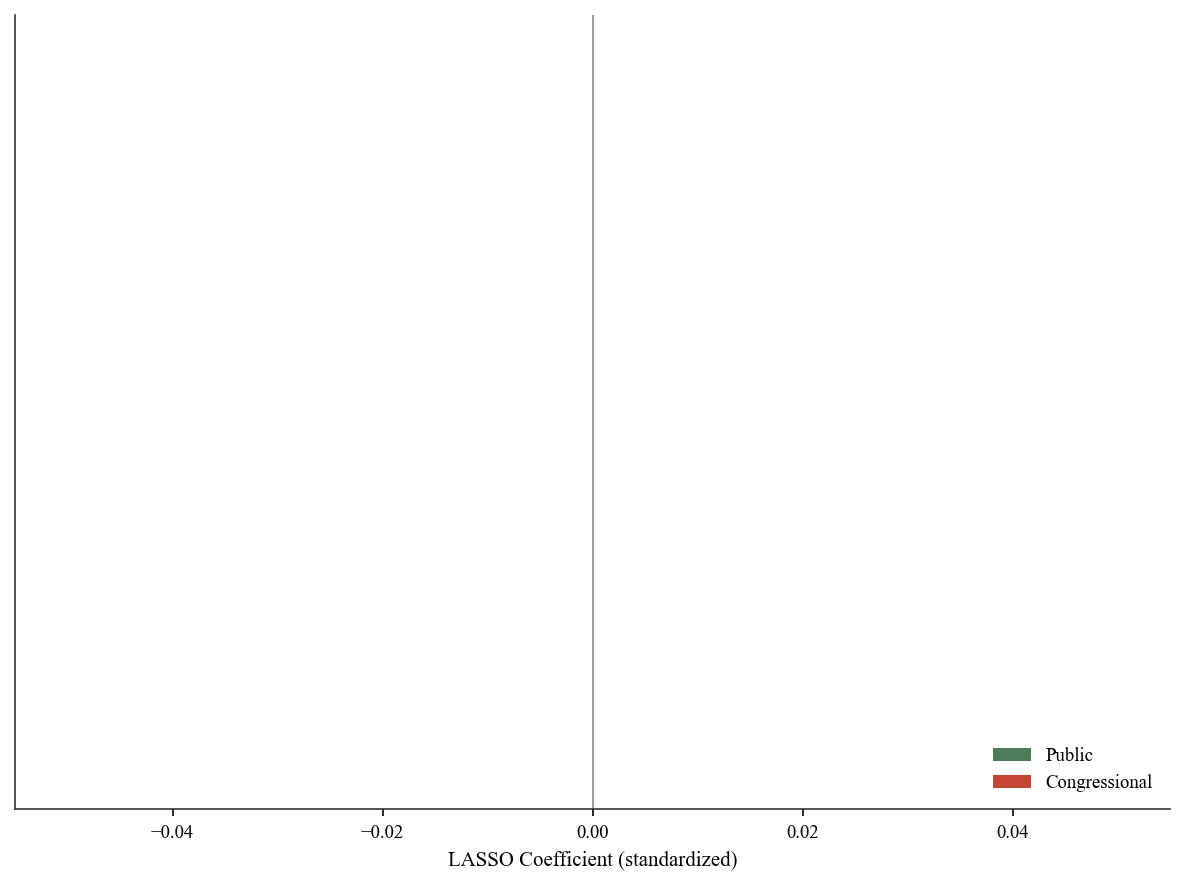

In [17]:
# Figure 5: LASSO Coefficients
fig, ax = plt.subplots(figsize=(8, 6))

top_n = 20
top_features = selected.head(top_n).copy()
top_features = top_features.sort_values('Coefficient')

# Color by public vs congressional
colors = [COLORS['congress'] if 'cong_' in f else COLORS['public'] 
          for f in top_features['Feature']]

bars = ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors, 
               edgecolor='white', linewidth=0.5)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=8)
ax.axvline(0, color=COLORS['neutral'], linewidth=0.8)
ax.set_xlabel('LASSO Coefficient (standardized)')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['public'], label='Public'),
    Patch(facecolor=COLORS['congress'], label='Congressional')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/lasso_coefficients.pdf')
plt.savefig(f'{OUTPUT_DIR}/lasso_coefficients.png')
plt.show()

In [18]:
# Permutation importance for Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=5, 
                           random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_scaled, y)

# Permutation importance
perm_imp = permutation_importance(rf, X_scaled, y, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1)

perm_imp_df = pd.DataFrame({
    'Feature': FEATURES_FULL,
    'Importance': perm_imp.importances_mean,
    'Std': perm_imp.importances_std
}).sort_values('Importance', ascending=False)

print('\nTop 20 Features by Permutation Importance:')
print(perm_imp_df.head(20).to_string(index=False))


Top 20 Features by Permutation Importance:
                      Feature  Importance      Std
                 sp500_mom_3m    0.142276 0.020973
          cong_pct_contrarian    0.044965 0.009663
                    sp500_vol    0.034365 0.006390
                          vix    0.022357 0.005907
    cong_avg_disclosure_delay    0.020302 0.003603
               sp500_ret_lag2    0.016302 0.004368
       cong_long_delay_trades    0.014525 0.005785
       cong_total_sell_amount    0.011965 0.003878
     cong_pct_frequent_trader    0.010702 0.002778
cong_committee_related_trades    0.010671 0.003479
        cong_total_buy_amount    0.010649 0.002652
                   cong_csi_R    0.010167 0.002743
               cong_dem_sells    0.010059 0.002786
           cong_concentration    0.009747 0.002499
                sp500_ret_lag    0.009544 0.002005
              cong_pct_hidden    0.008325 0.002413
              cong_pct_senior    0.006892 0.002027
         cong_high_vol_trades    0.006

In [ ]:
# Figure 6: Permutation Importance
fig, ax = plt.subplots(figsize=(8, 6))

top_n = 20
top_perm = perm_imp_df.head(top_n).copy()
top_perm = top_perm.sort_values('Importance')

colors = [COLORS['congress'] if 'cong_' in f else COLORS['public'] 
          for f in top_perm['Feature']]

bars = ax.barh(range(len(top_perm)), top_perm['Importance'], 
               xerr=top_perm['Std'], color=colors, edgecolor='white', 
               linewidth=0.5, capsize=2)

ax.set_yticks(range(len(top_perm)))
ax.set_yticklabels(top_perm['Feature'], fontsize=8)
ax.axvline(0, color=COLORS['neutral'], linewidth=0.8)
ax.set_xlabel('Permutation Importance (decrease in R²)')

legend_elements = [
    Patch(facecolor=COLORS['public'], label='Public'),
    Patch(facecolor=COLORS['congress'], label='Congressional')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/permutation_importance.pdf')
plt.savefig(f'{OUTPUT_DIR}/permutation_importance.png')
plt.show()

## 9. Summary Statistics

In [ ]:
# Congressional feature statistics by category
categories = {
    'Direction': ['cong_csi', 'cong_csi_volume', 'cong_net', 'cong_buy_ratio'],
    'Timing': ['cong_avg_disclosure_delay', 'cong_pct_long_delay', 'cong_pct_end_of_month'],
    'Coordination': ['cong_pct_coordinated', 'cong_pct_party_coordinated', 'cong_pct_committee_coordinated'],
    'Power': ['cong_pct_chair', 'cong_pct_senior', 'cong_avg_power_index'],
    'Relevance': ['cong_pct_committee_related', 'cong_pct_info_committee'],
    'Context': ['cong_pct_contrarian', 'cong_pct_high_vol', 'cong_pct_illiquid'],
    'Composite': ['cong_pct_smart_money', 'cong_pct_insider_ring', 'cong_strong_buy'],
}

print('Congressional Feature Summary Statistics')
print('='*60)

for cat, features in categories.items():
    available = [f for f in features if f in base.columns]
    if available:
        print(f'\n{cat}:')
        print(base[available].describe().loc[['mean', 'std', 'min', 'max']].round(4).T.to_string())

## 10. Export Results

In [ ]:
# Save results
results_df.to_csv(f'{OUTPUT_DIR}/model_comparison_results.csv', index=False)
cw_df.to_csv(f'{OUTPUT_DIR}/clark_west_tests.csv', index=False)
lasso_coef.to_csv(f'{OUTPUT_DIR}/lasso_coefficients.csv', index=False)
perm_imp_df.to_csv(f'{OUTPUT_DIR}/permutation_importance.csv', index=False)

print(f'Results saved to {OUTPUT_DIR}/')

## 11. Summary

In [ ]:
print('='*70)
print('MODEL 1: SUMMARY')
print('='*70)

print('\nDATA:')
print(f'  Observations: {len(base)}')
print(f'  Period: {base.index.min()} to {base.index.max()}')
print(f'  Public features: {len(FEATURES_PUBLIC)}')
print(f'  Congressional features: {len(FEATURES_CONGRESS)}')

print('\nKEY RESULTS:')

# Best improvement
best_improvement = pivot['Improvement'].max()
best_model = pivot['Improvement'].idxmax()
print(f'  Largest improvement: {best_improvement:.3f} pp ({best_model})')

# Average improvement
avg_improvement = pivot['Improvement'].mean()
print(f'  Average improvement: {avg_improvement:.3f} pp')

# Significant models
n_sig = (cw_df['CW_pval'] < 0.10).sum()
print(f'  Models with significant CW test (p<0.10): {n_sig}/{len(cw_df)}')

# Top congressional features
top_cong = selected[selected['Feature'].str.startswith('cong_')].head(5)
print(f'\nTOP PREDICTIVE CONGRESSIONAL FEATURES (LASSO):')
for _, row in top_cong.iterrows():
    print(f'  {row["Feature"]}: {row["Coefficient"]:.4f}')

print('\nINTERPRETATION:')
if avg_improvement > 0 and n_sig > 0:
    print('  Congressional trading activity contains predictive information')
    print('  about future S&P 500 returns not captured by public variables.')
    print('  This is consistent with Grossman-Stiglitz (1980): informed traders')
    print('  with low information costs participate actively in markets.')
else:
    print('  Limited evidence that congressional trading improves prediction.')

print('\nCAVEATS (Mullainathan-Spiess 2017):')
print('  - Predictive power ≠ causal effect')
print('  - Variable importance ≠ economic mechanism')
print('  - Out-of-sample performance may vary in future periods')

print('\nOUTPUT FILES:')
for f in os.listdir(OUTPUT_DIR):
    print(f'  {OUTPUT_DIR}/{f}')

print('\n' + '='*70)